## Inventory Forecasting Analysis

In [1]:
#Grab historical Sales data
#Seasonality Variables, Qtr, Period
#Event sku?
# Sku age
# CPI
%matplotlib inline

In [19]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")

import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts
import numpy as np

In [4]:
helper = HelperPI.Helper()

INFO:root:Initializing...


### Grabbing the data via pyodbc

In [51]:
sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\InventoryForecasting.sql")

In [52]:
base, dtypesdf = helper.readData(sql)

INFO:root:Reading data...
INFO:root:Data read complete...
INFO:root:Read: 55609 rows.


                   Count     Column Type
0      FIRST_DAY_OF_WEEK  datetime64[ns]
1       CALENDAR_QUARTER           int64
2                  MNTH1           int64
3                  MNTH2           int64
4                  MNTH3           int64
5                  MNTH4           int64
6                  MNTH5           int64
7                  MNTH6           int64
8                  MNTH7           int64
9                  MNTH8           int64
10                 MNTH9           int64
11                MNTH10           int64
12                MNTH11           int64
13                MNTH12           int64
14          HOLIDAY_WEEK           int64
15               UMCSENT         float64
16          STORE_NUMBER          object
17  STYLE_DISPLAY_NUMBER          object
18    SKU_DISPLAY_NUMBER          object
19                 PRICE         float64
20               SKU_AGE           int64
21             EVENT_SKU           int64
22          TARGET_UNITS         float64
23             L

In [53]:
base.describe()

,CALENDAR_QUARTER,MNTH1,MNTH2,MNTH3,MNTH4,MNTH5,MNTH6,MNTH7,MNTH8,MNTH9,MNTH10,MNTH11,MNTH12,HOLIDAY_WEEK,UMCSENT,PRICE,SKU_AGE,EVENT_SKU,TARGET_UNITS,LOG_UNITS
count,55609.000000,55609.000000,55609.000000,55609.000000,55609.000000,55609.000000,55609.000000,55609.000000,55609.000000,55609.00000,55609.000000,55609.000000,55609.000000,55609.000000,55609.000000,5.560900e+04,55609.000000,55609.000000,55609.000000,55609.000000
mean,2.483825,0.114046,0.085256,0.088349,0.077811,0.085454,0.056681,0.058498,0.075312,0.07952,0.077955,0.112302,0.088817,0.165585,90.716684,1.199000e+01,5783.177759,0.014314,20.041306,0.975951
std,1.176101,0.317870,0.279265,0.283804,0.267877,0.279558,0.231235,0.234684,0.263896,0.27055,0.268103,0.315740,0.284481,0.371711,5.165087,7.030884e-12,562.057884,0.118784,44.687719,0.499263
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,80.000000,1.199000e+01,4642.000000,0.000000,1.000000,0.301030
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,87.200000,1.199000e+01,6060.000000,0.000000,3.000000,0.602060
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,91.300000,1.199000e+01,6060.000000,0.000000,7.000000,0.903090
75%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,94.700000,1.199000e+01,6060.000000,0.000000,19.000000,1.301030
max,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,98.500000,1.199000e+01,6060.000000,1.000000,1152.000000,3.061829


In [54]:
base.head()

,FIRST_DAY_OF_WEEK,CALENDAR_QUARTER,MNTH1,MNTH2,MNTH3,MNTH4,MNTH5,MNTH6,MNTH7,MNTH8,...,HOLIDAY_WEEK,UMCSENT,STORE_NUMBER,STYLE_DISPLAY_NUMBER,SKU_DISPLAY_NUMBER,PRICE,SKU_AGE,EVENT_SKU,TARGET_UNITS,LOG_UNITS
0,2013-12-29,1,1,0,0,0,0,0,0,0,...,0,81.2,001,52552116,1138533,11.99,4642,0,5.0,0.778151
1,2013-12-29,1,1,0,0,0,0,0,0,0,...,0,81.2,001,52552116,876271,11.99,6060,0,10.0,1.041393
2,2013-12-29,1,1,0,0,0,0,0,0,0,...,0,81.2,001,52552116,876270,11.99,6060,0,12.0,1.113943
3,2013-12-29,1,1,0,0,0,0,0,0,0,...,1,81.2,001,52552116,1138533,11.99,4642,0,5.0,0.778151
4,2013-12-29,1,1,0,0,0,0,0,0,0,...,0,81.2,001,52552116,876269,11.99,6060,0,63.0,1.806180


# Preliminary OLS results

In [55]:
formula = 'LOG_UNITS ~ C(MNTH1) + C(MNTH2) + C(MNTH3) + C(MNTH4) + C(MNTH5) + C(MNTH6) + C(MNTH7) + C(MNTH8) + C(MNTH10) + C(MNTH11) + C(MNTH12) + C(EVENT_SKU) + C(HOLIDAY_WEEK) + PRICE + SKU_AGE + UMCSENT'
model = sts.ols(formula, data=base).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LOG_UNITS   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2102.
Date:                Tue, 12 Sep 2017   Prob (F-statistic):               0.00
Time:                        13:38:28   Log-Likelihood:                -27784.
No. Observations:               55609   AIC:                         5.560e+04
Df Residuals:                   55593   BIC:                         5.574e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0009      0.000     -3.793      0.000      -0.001      -0.000
C(MNTH1)[T.1]            0.2236      0.008     27.845      0.000       0.208       0.239
C(MNTH2)[T.1]            0.1294      0.009     15.180      0.000       0.113       0.146
C(MNTH3)[T.1]           -0.0287      0.008     -3.416      0.001      -0.045      -0.012
C(MNTH4)[T.1]           -0.1276      0.009    -14.618      0.000      -0.145      -0.110
C(MNTH5)[T.1]           -0.1884      0.008    -22.369      0.000      -0.205      -0.172
C(MNTH6)[T.1]           -0.1841      0.009    -19.658      0.000      -0.202      -0.166
C(MNTH7)[T.1]           -0.1893      0.009    -20.524      0.000      -0.207      -0.171
C(MNTH8)[T.1]           -0.0981      0.009    -11.391      0.000      -0.115      -0.081
C(MNTH10)[T.1]           0.1963      0.009     21.744      0.000       0.179       0.214
C(MNTH11)[T.1]           0.3718      0.008     46.810      0.000       0.356       0.387
C(MNTH12)[T.1]           0.6546      0.009     75.328      0.000       0.638       0.672
C(EVENT_SKU)[T.1]        0.7718      0.015     49.835      0.000       0.741       0.802
C(HOLIDAY_WEEK)[T.1]    -0.1171      0.005    -23.750      0.000      -0.127      -0.107
PRICE                   -0.0114      0.003     -3.793      0.000      -0.017      -0.005
SKU_AGE                  0.0003   3.02e-06     96.282      0.000       0.000       0.000
UMCSENT                 -0.0072      0.000    -20.233      0.000      -0.008      -0.007
==============================================================================
Omnibus:                      644.585   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              673.402
Skew:                           0.255   Prob(JB):                    5.92e-147
Kurtosis:                       3.173   Cond. No.                     1.36e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Data Description

In [56]:
#a = model.get_influence()
#a.summary_table()

### Point Biserial Correlation
For Target_Units vs the Event Sku flag.

In [57]:
corr, pval = stats.pointbiserialr(base['HOLIDAY_WEEK'], base['LOG_UNITS'])
print('Point Biserial Correlation \n Coeff: ' + str(corr) + '\n pval: ' + str(pval))

Point Biserial Correlation 
 Coeff: -0.00815900557956
 pval: 0.0543533781637


In [59]:
dtypesdf
columns = ['MNTH1','MNTH2','MNTH3','MNTH4','MNTH5','MNTH6','MNTH7','MNTH8','MNTH10','MNTH11','MNTH12','HOLIDAY_WEEK',
          'PRICE','EVENT_SKU','LOG_UNITS']

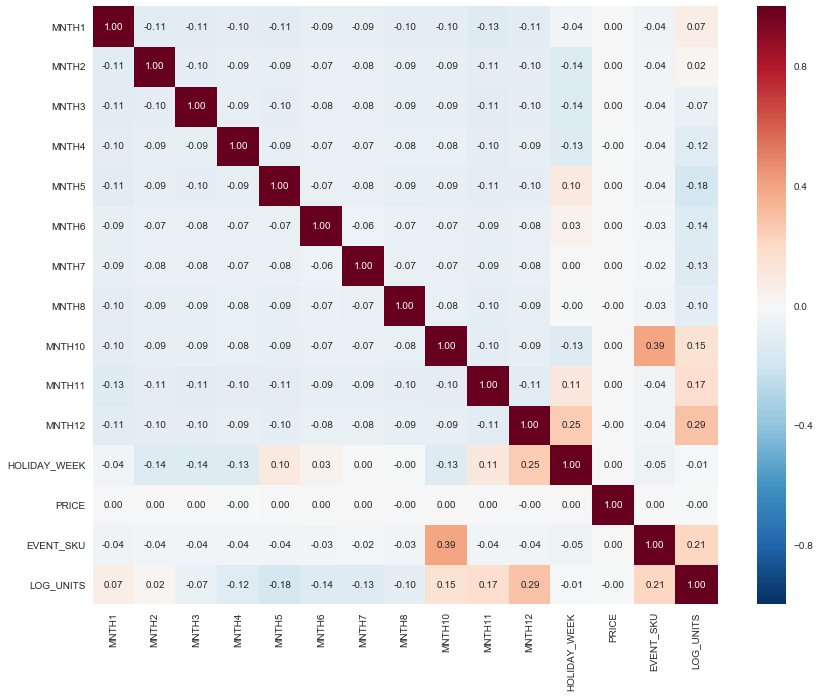

In [60]:
LM = base[columns]
cm = np.corrcoef(LM.values.T)
sns.set(font_scale=1)
cols = LM.columns.values
cols2 = cols.tolist()
fig, ax = plt.subplots(figsize = (14, 11))
hm = sns.heatmap(cm, 
                 cbar=True, 
                 annot=True,
                 #square=True,
                 fmt='.2f',
                 annot_kws={'size':10},
                 yticklabels=cols2,
                 xticklabels=cols2,
                 )
plt.show()
fig.savefig('corrplot.png')


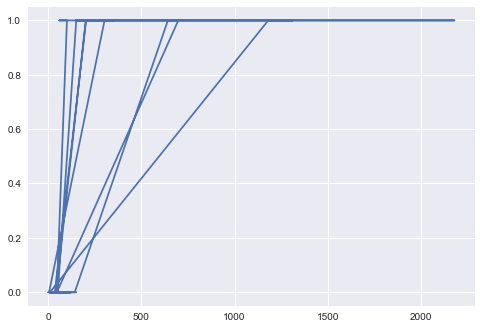

In [28]:
plt.plot(LM['TARGET_UNITS'],LM['EVENT_SKU'])
plt.show()